In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
# URL dari dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# untuk mengunduh file dari URL
response = requests.get(url)
with open('Online_Retail.xlsx', 'wb') as f:
    f.write(response.content)

# Membaca file Excel yang sudah diunduh ke dalam DataFrame
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Missing values
df.isna().sum()

# Duplicate rows
df.duplicated().sum()

# Transaksi cancel
df['InvoiceNo'].astype(str).str.startswith('C').value_counts()

# Cek nilai tidak valid
(df['Quantity'] <= 0).sum(), (df['UnitPrice'] <= 0).sum()

(np.int64(10624), np.int64(2517))

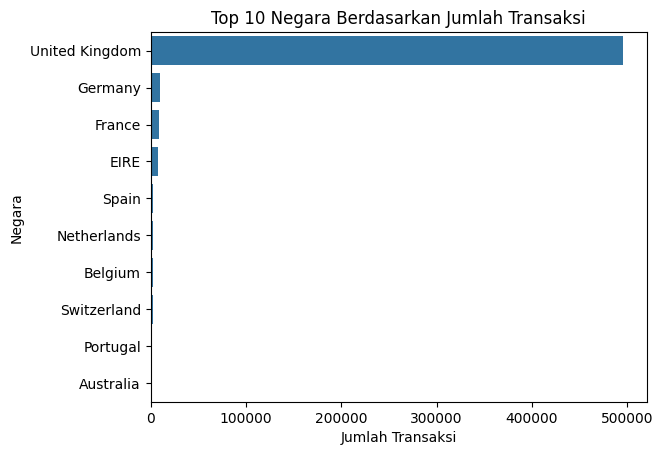

In [4]:
top_country = df['Country'].value_counts().head(10)

plt.figure()
sns.barplot(x=top_country.values, y=top_country.index)
plt.title("Top 10 Negara Berdasarkan Jumlah Transaksi")
plt.xlabel("Jumlah Transaksi")
plt.ylabel("Negara")
plt.show()

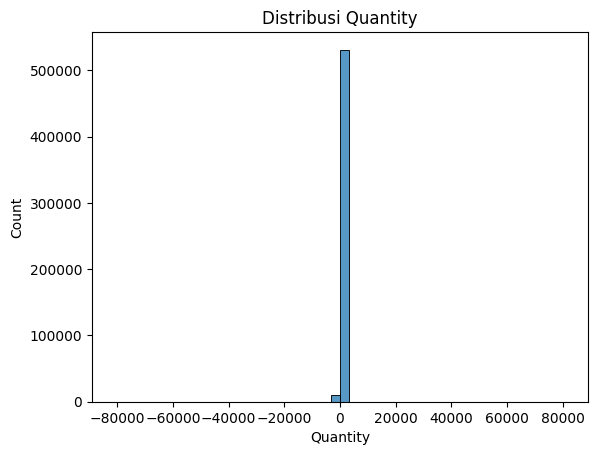

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df['Quantity'], bins=50)
plt.title("Distribusi Quantity")
plt.show()

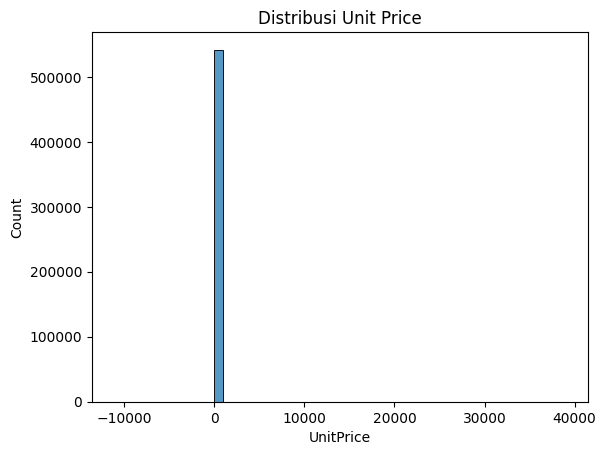

In [6]:
plt.figure()
sns.histplot(df['UnitPrice'], bins=50)
plt.title("Distribusi Unit Price")
plt.show()

In [7]:
# Copy dataset
df_clean = df.copy()

# Drop missing CustomerID
df_clean = df_clean.dropna(subset=['CustomerID'])

# Remove cancelled transactions
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Remove invalid values
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Remove duplicates
df_clean = df_clean.drop_duplicates()

# Data type conversion
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean.shape

(392692, 8)

In [8]:
# Create TotalPrice feature
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Snapshot date
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [10]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled[:5]

array([[ 2.33457414, -0.4250965 ,  8.36301037],
       [-0.90534032,  0.3544168 ,  0.2516989 ],
       [-0.17535959, -0.03533985, -0.02798783],
       [-0.73534481, -0.4250965 , -0.03240559],
       [ 2.17457836, -0.4250965 , -0.19081155]])

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init="auto"
)

labels_kmeans = kmeans.fit_predict(rfm_scaled)

silhouette_kmeans = silhouette_score(rfm_scaled, labels_kmeans)
silhouette_kmeans

np.float64(0.6162275299061803)

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=4,
    random_state=42
)

labels_gmm = gmm.fit_predict(rfm_scaled)

silhouette_gmm = silhouette_score(rfm_scaled, labels_gmm)
silhouette_gmm

np.float64(0.16285268997077484)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

input_dim = rfm_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
x = Dense(8, activation='relu')(input_layer)
latent = Dense(2, activation='relu', name='latent')(x)
x = Dense(8, activation='relu')(latent)
output_layer = Dense(input_dim, activation='linear')(x)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
#traiining

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = autoencoder.fit(
    rfm_scaled,
    rfm_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6227 - val_loss: 0.7661
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6047 - val_loss: 0.6523
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4534 - val_loss: 0.5896
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4848 - val_loss: 0.5496
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4644 - val_loss: 0.5230
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3626 - val_loss: 0.5016
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3416 - val_loss: 0.4800
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3455 - val_loss: 0.4665
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2858 - val_loss: 0.4496
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3737 - val_loss: 0.4331
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2996 - val_loss: 0.2827
Epoch 12/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

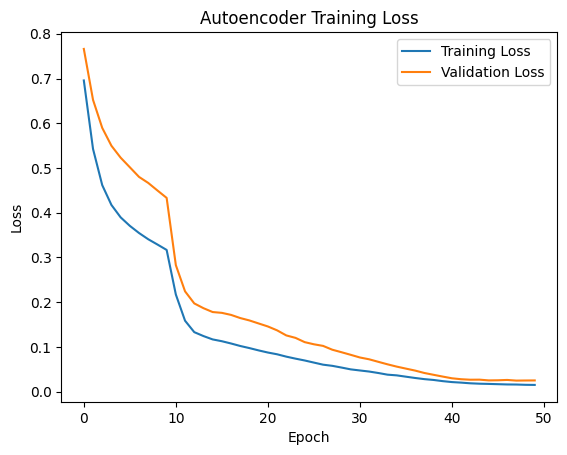

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

def evaluate_clustering(X, labels, model_name):
    return {
        "Model": model_name,
        "Silhouette Score": silhouette_score(X, labels),
        "Davies-Bouldin Index": davies_bouldin_score(X, labels),
        "Calinski-Harabasz Index": calinski_harabasz_score(X, labels)
    }

results = []

results.append(evaluate_clustering(rfm_scaled, labels_kmeans, "K-Means"))
results.append(evaluate_clustering(rfm_scaled, labels_gmm, "GMM"))

# Extract latent features from the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent').output)
latent_features = encoder.predict(rfm_scaled)

# Apply K-Means to the latent features
kmeans_ae = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels_ae = kmeans_ae.fit_predict(latent_features)

results.append(evaluate_clustering(latent_features, labels_ae, "Autoencoder + K-Means"))

evaluation_df = pd.DataFrame(results)
evaluation_df

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,K-Means,0.616228,0.754173,3145.058459
1,GMM,0.162853,1.620143,894.830724
2,Autoencoder + K-Means,0.570008,0.617902,4172.640137


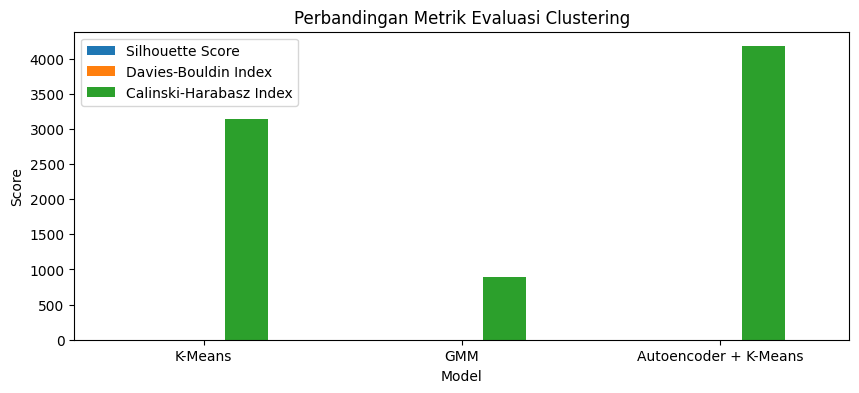

In [19]:
evaluation_df.set_index("Model").plot(kind="bar", figsize=(10,4))
plt.title("Perbandingan Metrik Evaluasi Clustering")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [20]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# Save K-Means
joblib.dump(kmeans, "models/kmeans_model.pkl")

# Save GMM
joblib.dump(gmm, "models/gmm_model.pkl")

# Save scaler
joblib.dump(scaler, "models/scaler.pkl")

print("K-Means, GMM, dan Scaler berhasil disimpan.")


K-Means, GMM, dan Scaler berhasil disimpan.


In [21]:
# Save autoencoder
autoencoder.save("models/autoencoder.h5")

# Save encoder (latent model)
encoder.save("models/encoder.h5")

print("Autoencoder dan Encoder berhasil disimpan.")

Autoencoder dan Encoder berhasil disimpan.
